## Importar librerias y requerimientos

In [1]:
!pip install pandana

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler , RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5


## Leer dataset

In [16]:
df = pd.read_csv('processed_data_listings.csv')
df= df[df['price'] > 0]
df= df[df['price'] < 500]
df = df.drop(columns = ['id'])
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Tower Hamlets,51.52874,-0.05396,Private room,55,3,1,74,0
1,Islington,51.56861,-0.11270,Private room,50,1,2,343,9
2,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,1,222,1
3,Islington,51.52478,-0.10484,Private room,180,4,5,236,20
4,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,1,180,2


## Funcion correlacion

In [17]:
def multi_collinearity_heatmap(df, figsize=(11,9)):

    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """

    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

## Codificado con hot-encoding

In [18]:
df_hot_encoding = pd.get_dummies(df, columns=['neighbourhood', 'room_type'], drop_first=True)

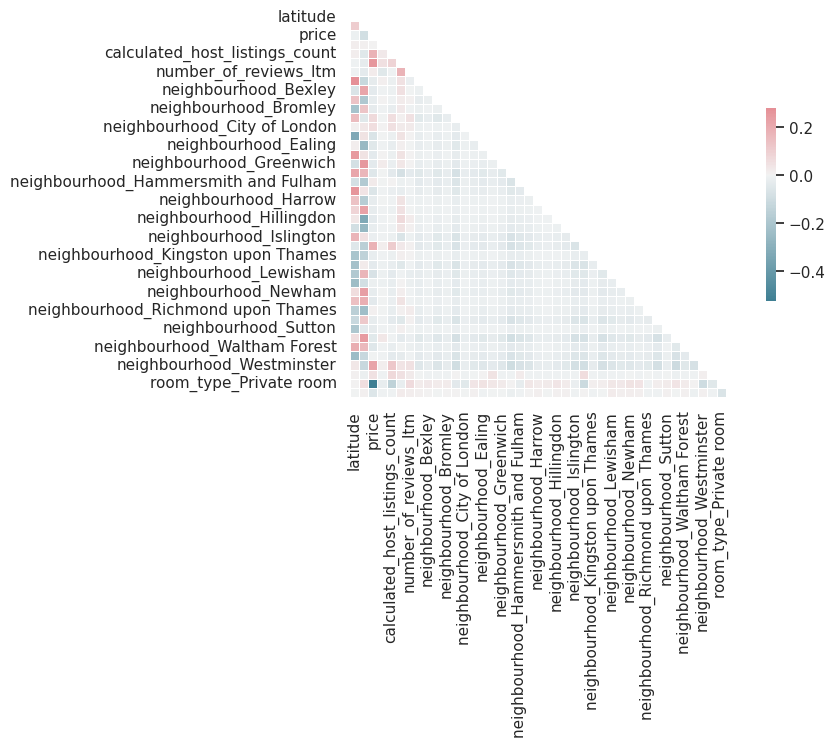

In [19]:
multi_collinearity_heatmap(df_hot_encoding, figsize=(8,5))

## Codificando con Label encoder

In [80]:
label_code = df.copy()
label_encoder = LabelEncoder()
# Ajusta y transforma la columna 'barrio' utilizando el LabelEncoder
label_code['neighbourhood_encoded'] = label_encoder.fit_transform(label_code['neighbourhood'])
label_code['room_type_encoded'] = label_encoder.fit_transform(label_code['room_type'])
label_code = label_code.drop(columns = ['neighbourhood','room_type'])
label_code

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_encoded,room_type_encoded
0,51.52874,-0.05396,55,3,1,74,0,29,2
1,51.56861,-0.11270,50,1,2,343,9,18,2
2,51.52851,-0.07426,90,5,1,222,1,29,0
3,51.52478,-0.10484,180,4,5,236,20,18,2
4,51.51464,-0.20004,297,14,1,180,2,19,0
...,...,...,...,...,...,...,...,...,...
67925,51.48300,-0.01346,55,5,3,0,1,10,2
67926,51.50914,-0.10192,201,3,1,0,12,27,0
67927,51.40571,-0.35325,246,3,1,4,6,26,0
67928,51.41029,-0.35975,250,3,1,2,4,26,0


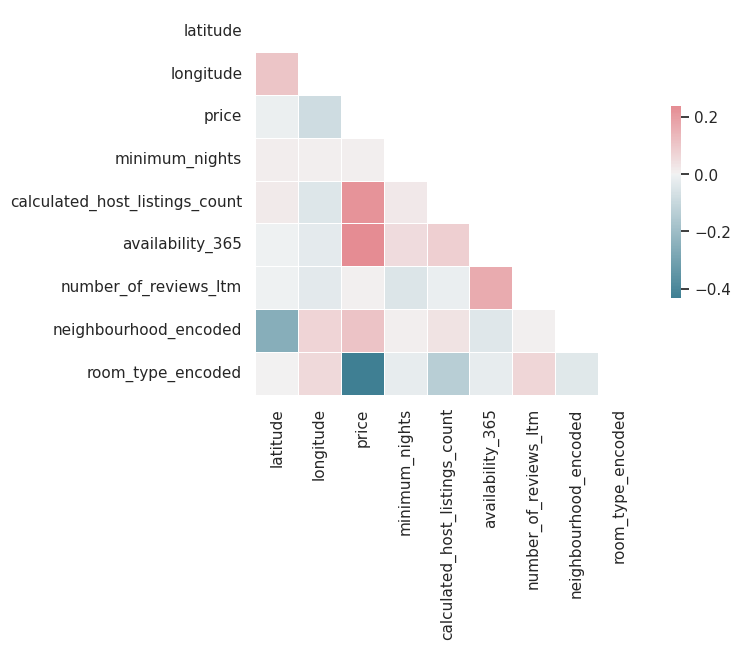

In [19]:
multi_collinearity_heatmap(label_code, figsize=(8,5))

## Encoding labelencoder: neighbourhood / one hot encoding: room_type

In [7]:
twice_encoding = df.copy()

label_encoder = LabelEncoder()

twice_encoding['neighbourhood_encoded'] = label_encoder.fit_transform(twice_encoding['neighbourhood'])
twice_encoding = twice_encoding.drop(columns = ['neighbourhood'])

twice_encoding = pd.get_dummies(twice_encoding, columns=['room_type'], drop_first=True)
twice_encoding

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_encoded,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,51.52874,-0.05396,55,3,1,74,0,29,0,1,0
1,51.56861,-0.11270,50,1,2,343,9,18,0,1,0
2,51.52851,-0.07426,90,5,1,222,1,29,0,0,0
3,51.52478,-0.10484,180,4,5,236,20,18,0,1,0
4,51.51464,-0.20004,297,14,1,180,2,19,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
67925,51.48300,-0.01346,55,5,3,0,1,10,0,1,0
67926,51.50914,-0.10192,201,3,1,0,12,27,0,0,0
67927,51.40571,-0.35325,246,3,1,4,6,26,0,0,0
67928,51.41029,-0.35975,250,3,1,2,4,26,0,0,0


In [8]:
twice_encoding.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'neighbourhood_encoded',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

## Standardising and normalising

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'minimum_nights'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>,
        <Axes: title={'center': 'availability_365'}>],
       [<Axes: title={'center': 'number_of_reviews_ltm'}>, <Axes: >,
        <Axes: >]], dtype=object)

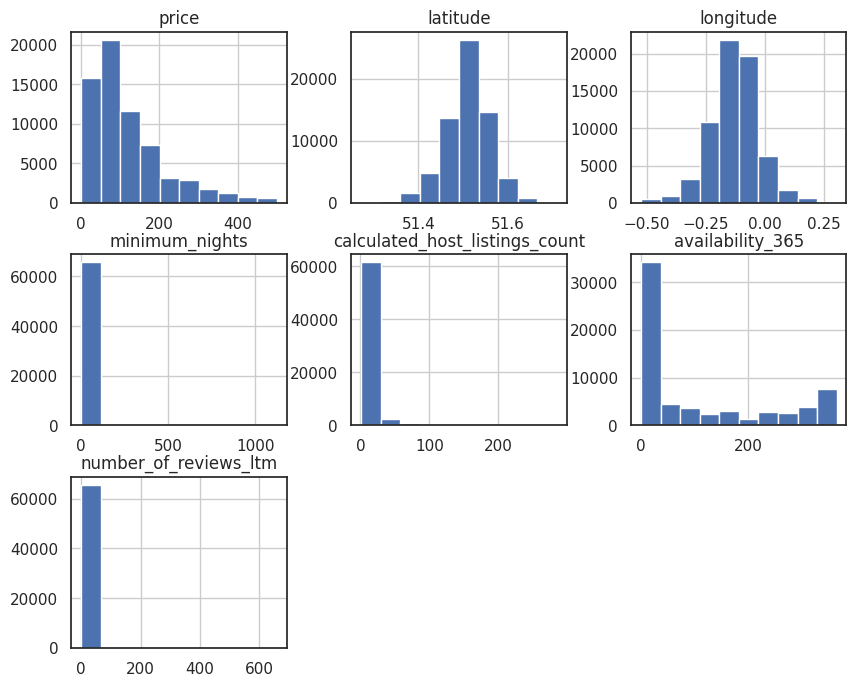

In [20]:
numeric_col = ['price', 'latitude', 'longitude','minimum_nights', 'calculated_host_listings_count','availability_365', 'number_of_reviews_ltm'] #, 'number_of_reviews_ltm'
df_hot_encoding[numeric_col].hist(figsize=(10,8))

In [21]:
# Log transforming columns
numerical_columns = [i for i in numeric_col
                     if i not in ['availability_365', 'latitude', 'longitude']] # Removing items not to be transformed

for col in numerical_columns:
    df_hot_encoding[col] = df_hot_encoding[col].astype('float64').replace(0.0, 0.05) # Replacing 0s with 0.01
    df_hot_encoding[col] = np.log(df_hot_encoding[col])

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'minimum_nights'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>,
        <Axes: title={'center': 'availability_365'}>],
       [<Axes: title={'center': 'number_of_reviews_ltm'}>, <Axes: >,
        <Axes: >]], dtype=object)

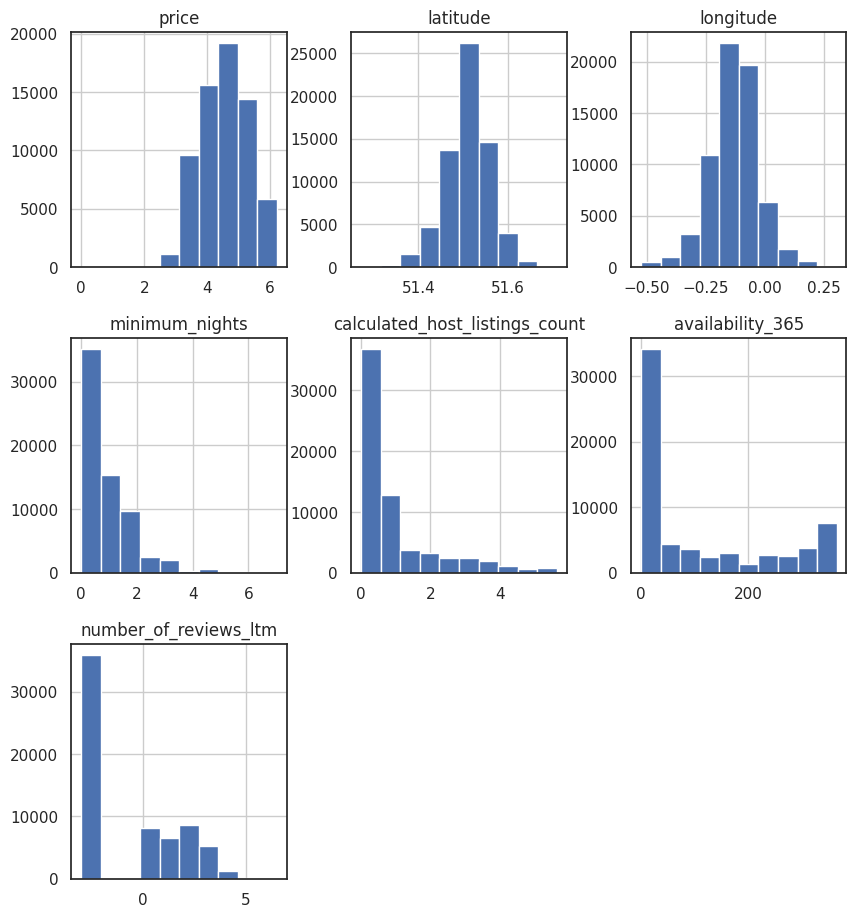

In [22]:
df_hot_encoding[numeric_col].hist(figsize=(10,11))


## Prepared data to model: train, test

In [14]:
# Separating X and y
X = df_hot_encoding.drop('price', axis=1)
y = df_hot_encoding.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [15]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Model 1: Regresion Lineal Spatial Hedonic Price Model (HPM)

In [114]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.3196
Validation RMSE: 0.3254

Training r2: 0.5058
Validation r2: 0.4994


In [115]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,5.192957,5.533934
1,4.060443,5.143236
2,3.367296,3.910685
3,4.077537,4.288480
4,4.553877,4.677209
...,...,...
13578,4.787492,5.246111
13579,5.545177,5.127051
13580,3.688879,4.631045
13581,4.007333,3.992959


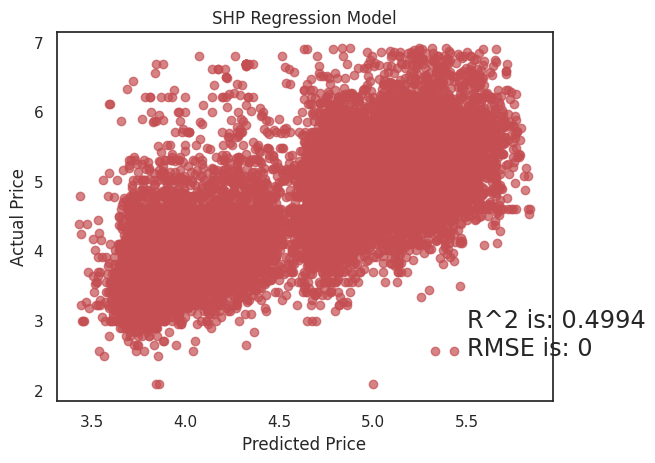

In [116]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate(text=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

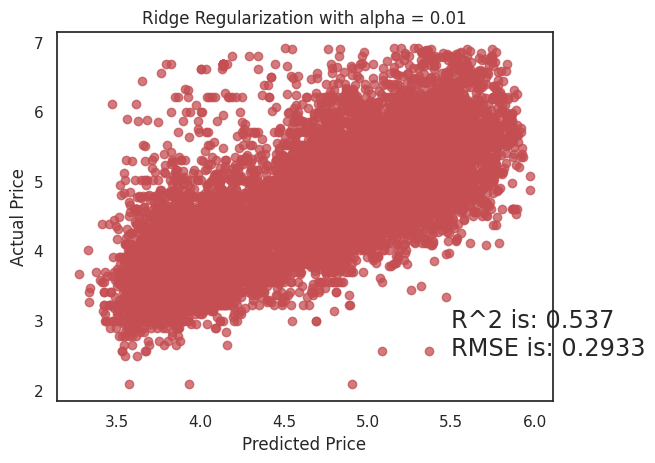

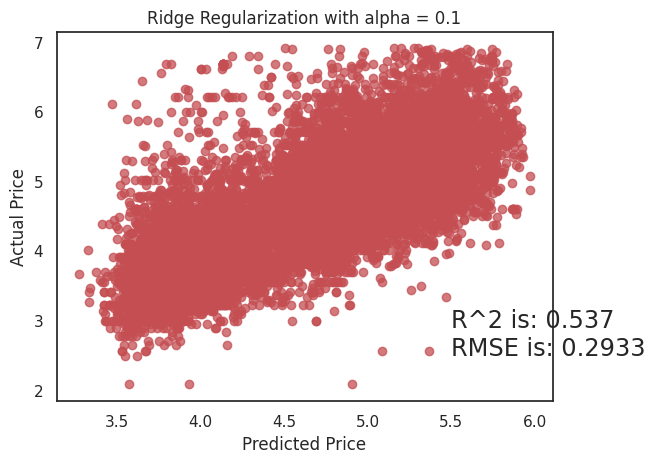

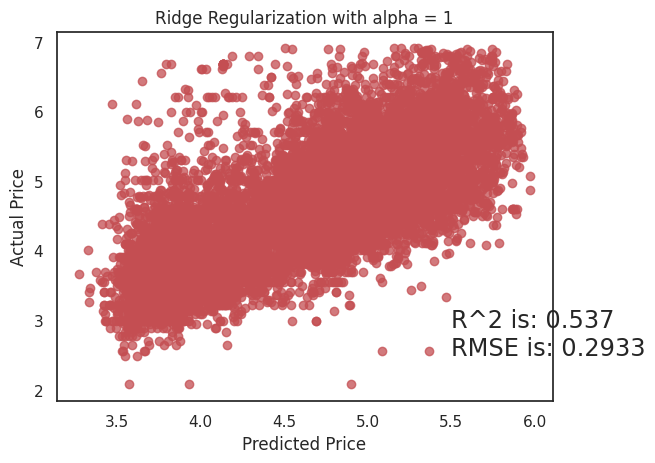

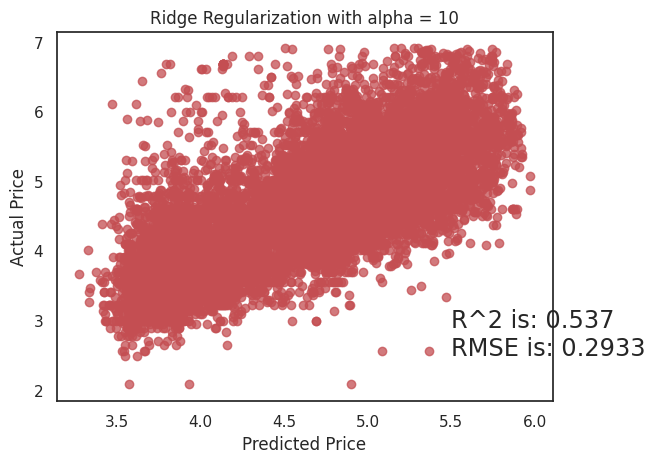

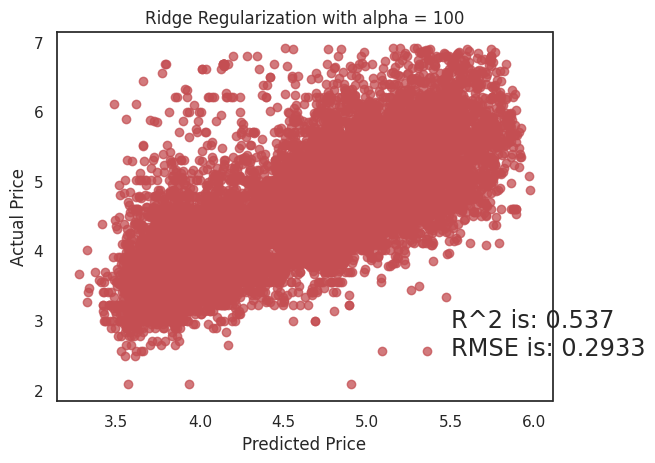

In [43]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( text=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

## Model 2: Decision Tree Regressor

In [94]:
from sklearn.model_selection import train_test_split
X = twice_encoding.drop('price', axis=1)
Y = twice_encoding.price
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_Y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_Y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, Y.shape))

Training set: Xt:(49428, 10) Yt:(49428,)
Validation set: Xv:(16477, 10) Yv:(16477,)
-
Full dataset: X:(65905, 10) Y:(65905,)


In [95]:
from sklearn.tree import DecisionTreeRegressor

lisbon_airbnb_model = DecisionTreeRegressor(random_state = 42)
lisbon_airbnb_model.fit(train_X, train_Y)

DecisionTreeRegressor(random_state=42)

In [96]:
# Supongamos que ya tienes tus datos X e y y quieres crear el modelo DecisionTreeRegressor
model = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                              max_leaf_nodes=None, min_samples_leaf=1,
                              min_samples_split=2, min_weight_fraction_leaf=0.0,
                              random_state=42, splitter='best')

In [97]:
from sklearn.metrics import mean_absolute_error

# instruct our model to make predictions for the prices on the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X)

# calculate the MAE between the actual prices (in validation_Y) and the predictions made
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

0.44832244893302786

In [98]:
# this function takes both the training and validation sets to compute the MAE for a Decision Tree
def compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes):
    trees_model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 42)
    trees_model.fit(train_X, train_Y)
    validation_predictions = trees_model.predict(validation_X)
    error = mean_absolute_error(validation_Y, validation_predictions)

    return(error)

def get_best_tree_size(train_X, train_Y, validation_X, validation_Y, verbose = False):
    # candidates to iterate on finding a better tree depth
    candidate_max_leaf_nodes = [5, 10, 20, 30, 50, 100, 250, 500]

    # initialization
    minimum_error = None
    best_tree_size = 5

    # loop to find the minimal error value
    for max_leaf_nodes in candidate_max_leaf_nodes:
        current_error = compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes)
        verbose and print("(Size: {}, MAE: {})".format(max_leaf_nodes, current_error))

        if(minimum_error == None or current_error < minimum_error):
            minimum_error = current_error
            best_tree_size = max_leaf_nodes

    return(best_tree_size)

best_tree_size = get_best_tree_size(train_X, train_Y, validation_X, validation_Y, True)

best_tree_size

(Size: 5, MAE: 0.41352595369484296)
(Size: 10, MAE: 0.40145214296772114)
(Size: 20, MAE: 0.3879789999820573)
(Size: 30, MAE: 0.3824299534691504)
(Size: 50, MAE: 0.37733463643788573)
(Size: 100, MAE: 0.36996915522804985)
(Size: 250, MAE: 0.3605059547879352)
(Size: 500, MAE: 0.3562959603392109)


500

In [99]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Supongamos que ya tienes tus datos X e y y quieres crear el modelo DecisionTreeRegressor
model = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                              max_leaf_nodes=None, min_samples_leaf=1,
                              min_samples_split=2, min_weight_fraction_leaf=0.0,
                              random_state=42, splitter='best')

# Predecir valores en el conjunto de prueba
validation_predictions = lisbon_airbnb_model.predict(validation_X)

# Calcular el coeficiente de determinación R^2
r2 = r2_score(validation_Y, validation_predictions)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(validation_Y, validation_predictions))

# Imprimir los resultados
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

R^2: 0.3599
RMSE: 0.5947


## Model 3: Random Forest

In [32]:
from sklearn.model_selection import train_test_split
X = df_hot_encoding.drop('price', axis=1)
Y = df_hot_encoding.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_Y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_Y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, Y.shape))

Training set: Xt:(49428, 41) Yt:(49428,)
Validation set: Xv:(16477, 41) Yv:(16477,)
-
Full dataset: X:(65905, 41) Y:(65905,)


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# let us set a maximum of 250 trees in our forest
random_forest_model = RandomForestRegressor(n_estimators = 800,random_state=42)

random_forest_model.fit(train_X, train_Y)
predictions = random_forest_model.predict(validation_X)

mae = mean_absolute_error(validation_Y, predictions)
r2 = r2_score(validation_Y, predictions)
rmse = np.sqrt(mean_squared_error(validation_Y, predictions))

print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.3292
R^2: 0.6649
RMSE: 0.4303


In [ ]:
                                            criterion = 'squared_error',
                                            max_depth = 8,
                                            max_features='auto',
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=42

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predecir valores en el conjunto de prueba
validation_predictions = airbnb_lisbon_forest_model.predict(validation_X)

# Calcular el coeficiente de determinación R^2
r2 = r2_score(validation_Y, validation_predictions)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(validation_Y, validation_predictions))

# Imprimir los resultados
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

R^2: 0.6591
RMSE: 0.4340


## Model 4: Gradient boosting

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# Supongamos que ya tienes tu DataFrame con las características 'X' y el objetivo 'y'
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo Gradient Boosting de Regresión
model = GradientBoostingRegressor(random_state=42)

# Definir los hiperparámetros a probar en la búsqueda
param_grid = {
    'n_estimators': [150, 600, 800],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 8, 10]
}

# Definir la métrica a optimizar (por ejemplo, el MAE)
scoring = make_scorer(mean_absolute_error)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba utilizando el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular el MAE en el conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir los resultados
print("Mejores hiperparámetros encontrados:")
print(best_params)
print(f'MAE en el conjunto de prueba con los mejores hiperparámetros: {mae:.4f}')
print(f'R2 en el conjunto de prueba con los mejores hiperparámetros: {r2:.4f}')
print(f'RMSE en el conjunto de prueba con los mejores hiperparámetros: {rmse:.4f}')

Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
MAE en el conjunto de prueba con los mejores hiperparámetros: 0.5279


In [181]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# Supongamos que ya tienes tu DataFrame con las características 'X' y el objetivo 'y'
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear el modelo Gradient Boosting de Regresión
model = GradientBoostingRegressor(loss='squared_error', n_estimators=400, learning_rate=0.1, max_depth=20, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el R^2
r2 = r2_score(y_test, y_pred)

# Calcular el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir los resultados
print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.3522
R^2: 0.6044
RMSE: 0.4665


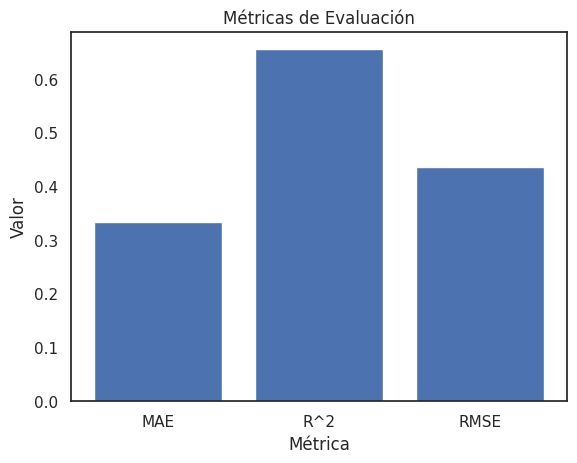

In [179]:
metric_labels = ['MAE', 'R^2', 'RMSE']
metric_values = [mae, r2, rmse]

plt.bar(metric_labels, metric_values)
plt.title('Métricas de Evaluación')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.show()


## XGBOOST

In [23]:
from sklearn.model_selection import train_test_split
X = df_hot_encoding.drop('price', axis=1)
Y = df_hot_encoding.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_Y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_Y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, Y.shape))

Training set: Xt:(49428, 41) Yt:(49428,)
Validation set: Xv:(16477, 41) Yv:(16477,)
-
Full dataset: X:(65905, 41) Y:(65905,)


In [32]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 200, seed = 123, gamma = 0.2)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
xgb_model.fit(train_X, train_Y)

# Hacer predicciones en el conjunto de prueba
y_pred = xgb_model.predict(validation_X)

# Calcular las métricas de evaluación
mae = mean_absolute_error(validation_Y, y_pred)
r2 = r2_score(validation_Y, y_pred)
rmse = np.sqrt(mean_squared_error(validation_Y, y_pred))

# Imprimir los resultados
print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.3350
R^2: 0.6606
RMSE: 0.4321


## Metricas evaluacion

In [6]:
import pandas as pd

# Definir los nombres de los modelos
model_names = ['linear_regression', 'gradient_boost', 'random_forest']

# Definir las métricas de cada modelo
mae_train = [0.3895, 0.2601, 0.1236]
r2_train = [0.5595, 0.7961, 0.9525]
rmse_train = [0.4940, 0.3367, 0.1626]
mae_val = [0.3906, 0.3327, 0.3271 ]
r2_val = [0.5615, 0.6635, 0.6647]
rmse_val = [0.4949, 0.4303,0.4295 ]

# Crear el DataFrame con los resultados de los modelos
results_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_val,
    'R^2': r2_val,
    'RMSE': rmse_val
})

# Imprimir el DataFrame
results_df

,Model,MAE,R^2,RMSE
0,linear_regression,0.3906,0.5615,0.4949
1,gradient_boost,0.3327,0.6635,0.4303
2,random_forest,0.3271,0.6647,0.4295


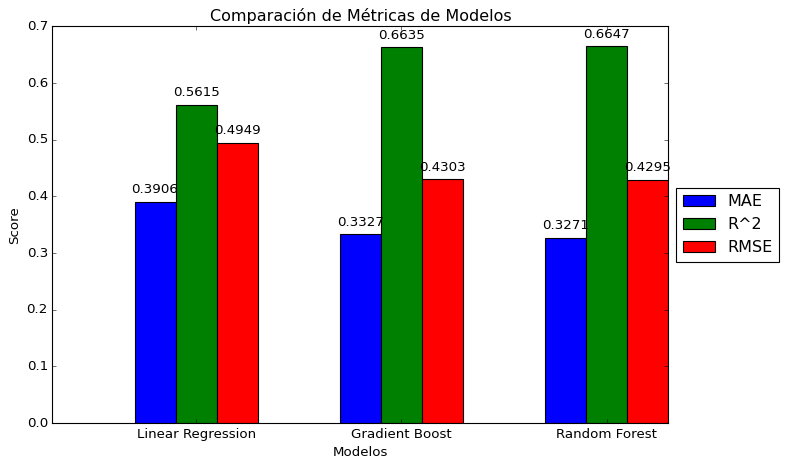

In [10]:
import matplotlib.pyplot as plt

# Datos de las métricas
models = ['Linear Regression', 'Gradient Boost', 'Random Forest']
mae = [0.3906, 0.3327, 0.3271]
r2 = [0.5615, 0.6635, 0.6647]
rmse = [0.4949, 0.4303, 0.4295]

# Configurar el estilo del gráfico
plt.style.use('classic')
plt.figure(figsize=(10, 6), facecolor='white')  # Ajustar el tamaño del gráfico

# Crear el gráfico de barras
width = 0.2
x = range(len(models))

plt.bar(x, mae, width, label='MAE')
plt.bar([i + width for i in x], r2, width, label='R^2')
plt.bar([i + 2 * width for i in x], rmse, width, label='RMSE')

# Personalizar el gráfico
plt.title('Comparación de Métricas de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Score')
plt.xticks([i + width for i in x], models)

# Agregar el valor encima de cada barra
for i, v in enumerate(mae):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
for i, v in enumerate(r2):
    plt.text(i + width, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
for i, v in enumerate(rmse):
    plt.text(i + 2 * width, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Posicionar las leyendas (labels) a un lado
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()